In [1]:
import pandas as pd
import numpy as np
# set random seed
np.random.seed(16)

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

%matplotlib inline  


# 0. Helper Functions

In [2]:
def lagp(x, p):
    x = list(x)

    if p >= 0:
        a = np.array([0] * p + x[0:len(x) - p])

    if p < 0:
        a = np.array(x[0 - p:len(x) - p] + [0] * (-p))
    return a

def transform_exp(x, alpha, lags):
    
    result = x.copy()
    sumWeight = 1
    ones = np.ones(len(result))
    for i in range(0,lags+1):
        result += alpha**i * lagp(x, i)
        sumWeight +=ones * alpha**i
        #print(alpha**i)
    result = result/sumWeight
    return result


## 1. Randomly Generate Input Data

Instead of using real spend data we have randomly generated a daily spend data set with four channels, aptly named 'channel 1', 'channel 2', 'channel 3', and 'channel 4'. 

From this randomly generated spend data we then generate some acquisition data. This acquisition data is created assuming some organic traffic and some organic growth rate, that each channel positively contirbutes to the acquisitions, and that there is a day of week effect. We also add a lot of noise. 

In [3]:
# Generate Random Spend Data
num_months = 24
days_in_month = 30
num_days = num_months * days_in_month

channel_base_spend = {
    1:12000,
    2:90000,
    3:40000,
    4:10000
}

input_data = np.zeros((num_days,6))
input_data[:,0]=np.arange(0,num_days)

general_spend_trend = 1+(-np.cos(input_data[:,0]/200) +1)/2

for channel in channel_base_spend.keys():
    channel_month_multiplier = np.repeat(np.random.rand(1,num_months),days_in_month)
    input_data[:,channel] = general_spend_trend*channel_month_multiplier*np.random.rand(1,num_days)*channel_base_spend[channel]



In [4]:
# Generate Acquisitions Data 

channel_exponents = {
    1:0.025,
    2:0.07,
    3:0.04,
    4:0.01
}

channel_scalars = {
    1:1/4000,
    2:1/25000,
    3:1/15000,
    4:1/6000
}

lag_alpha = {
    1: 0.7,
    2: 0,
    3: 0,
    4: 0.5,
}
# Add 7 day decay adstock lag to spend for channel 1 
# Add 4 day decay adstock lag to spend for channel 3 

lag_days = {
    1: 7,
    2: 0,
    3: 0,
    4: 4,
}

# Add organic trend to input
input_data[:,5] = 6000+3/4*(input_data[:,0])


# Add channel spend contributions
for channel in channel_exponents:
    input_data[:,5]*=np.log( transform_exp(input_data[:,channel],lag_alpha[channel], lag_days[channel]) \
        * channel_scalars[channel]+1)**channel_exponents[channel] 
    
# Add day of week contributions
dow_effects = np.tile(np.array([0.15, -0.1, -0.1, -0.1, 0, 0.05, 0.1]),num_days//7+1)[:num_days]
input_data[:,5] = input_data[:,5]*(1+dow_effects)

# Add gaussian noise
input_data[:,5] = input_data[:,5] + np.random.normal(loc=100, scale=100, size=(num_days))

input_data = np.round(input_data)

# put into a data frame for use later
input_df = pd.DataFrame(input_data, columns = ['day', 'channel_1', 'channel_2', 'channel_3', 'channel_4', 'acqs'])
dates = pd.date_range(pd.to_datetime('2016-05-01'), periods=input_df.shape[0]).tolist()
input_df['date']=dates
del(input_df['day'])

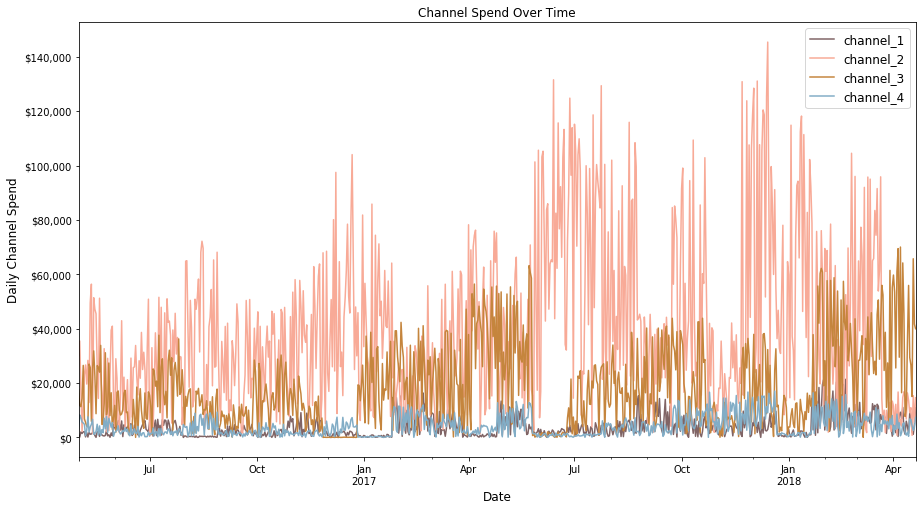

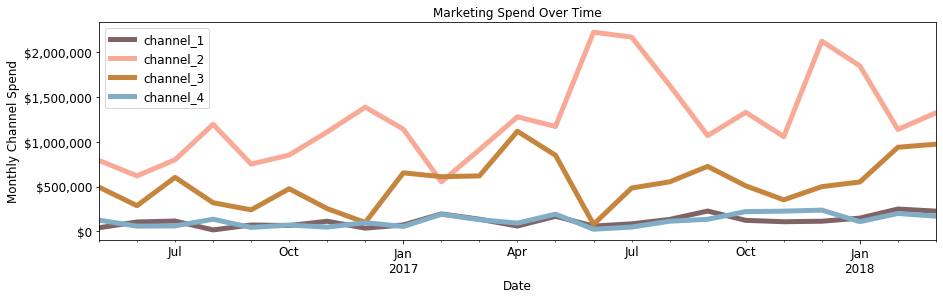

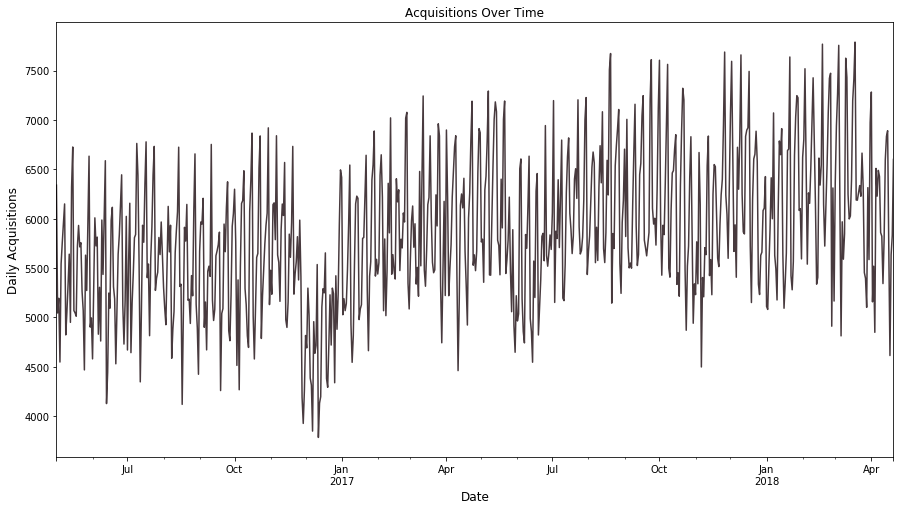

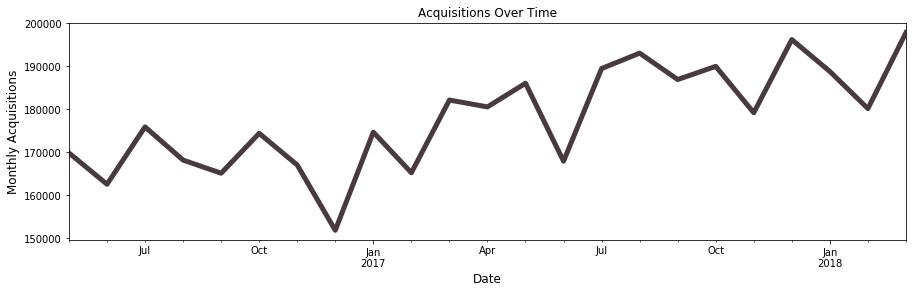

In [5]:
# put these next to each other 
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
# View Spend Data Daily

p1 = input_df.set_index('date')[['channel_1', 'channel_2', 'channel_3', 'channel_4']].plot(
    figsize=(15,8),  color = ['#806465','#f8aa97','#c5853d',  '#82adc6'],)
plt.legend( fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Channel Spend', fontsize=12)
plt.title('Channel Spend Over Time')
p1.yaxis.set_major_formatter(tick)
plt.show()

# View Spend Data Monthtly
input_df['month-year']=pd.to_datetime(input_df['date'].dt.month.astype(str) +'-'+ input_df['date'].dt.year.astype(str))
monthly_input = input_df[['channel_1', 'channel_2', 'channel_3', 'channel_4','acqs','month-year']].groupby('month-year').sum()
monthly_input = monthly_input.loc[monthly_input.index[:-1]]
del input_df['month-year']
ax = monthly_input[['channel_1', 'channel_2', 'channel_3', 'channel_4']].plot(
    figsize=(15,4), color = ['#806465','#f8aa97','#c5853d',  '#82adc6'], linewidth=5, fontsize = 12)
plt.ylabel('Monthly Channel Spend', fontsize = 12)
plt.legend( fontsize=12)
plt.xlabel('Date',fontsize = 12)
plt.title('Marketing Spend Over Time', fontsize = 12)
ax.yaxis.set_major_formatter(tick)
plt.show()

# View Acquisitions by Day
p2 =input_df.set_index('date')[['acqs']].plot(figsize=(15,8), legend = False, color = ['#483a3e'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Acquisitions', fontsize=12)
plt.title('Acquisitions Over Time')
plt.show()

# View Acquisitions by Day
p2 =monthly_input[['acqs']].plot(
    figsize=(15,4), legend = False, color = ['#483a3e'], linewidth=5)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Monthly Acquisitions', fontsize=12)
plt.title('Acquisitions Over Time')
plt.show()



In [6]:
# save data farmeinput_data
input_df.to_csv('spend_and_acquisitions_data.csv')